# Estimation and Forecast of Autoregressive processes (AR(p))

In [387]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
from numpy.fft import fftshift, fft
from scipy.linalg import toeplitz
import pandas as pd

In [388]:
# read in the data
data = list(genfromtxt('88.csv', delimiter=','))

## Estimating AR(p)

We first compute the periodogram and direct spectral estimate.

In [389]:
def periodogram(X):
    """
    Input:
        X: numpy array of the time series
    Output:
        The periodogram at the Fourier frequencies for X.
    """
    
    N = len(X)

    # Fourier frequencies
    f_k = np.arange(0,N)/N
    
    # Compute the periodogram using the method described above
    S = abs(fft(X)*(np.exp(-1j*2*np.pi*f_k)))**2/N

    return S

In [390]:
def direct(X,p):
    """
    Input:
        X: time series
        p: variable for cosine taper
    Output:
        Direct spectral estimate at the Fourier frequencies using px100% cosine taper for X.
    """
    
    N = len(X)

    interval = np.arange(0,N)  # range of the taper

    # create the three intervals for the taper
    interval1 = interval[0:int(np.floor(p*(N))/2)]
    interval2 = interval[int(np.floor(p*(N))/2): N - int(np.floor(p*N)/2)]
    interval3 = interval[N - int(np.floor(p*N)/2): ]

    # for each interval set the value of h
    h1 = 0.5*(1- np.cos(2*np.pi*(interval1+1)/(np.floor(p*N)+1)))
    h2 = np.ones(interval2.shape)
    h3 = 0.5*(1 - np.cos(2*np.pi*(N - interval3)/(np.floor(p*N)+1)))
    h = np.concatenate((h1, h2, h3))

    # normalize so that the sum of h_t^2 = 1
    h = h/np.sqrt(np.sum(h**2))

    # Fourier frequencies
    f_k = interval/N

    # compute the directral spectral estimator as described above
    S = abs(fft(h*X)*(np.exp(-1j*2*np.pi*f_k)))**2

    return S

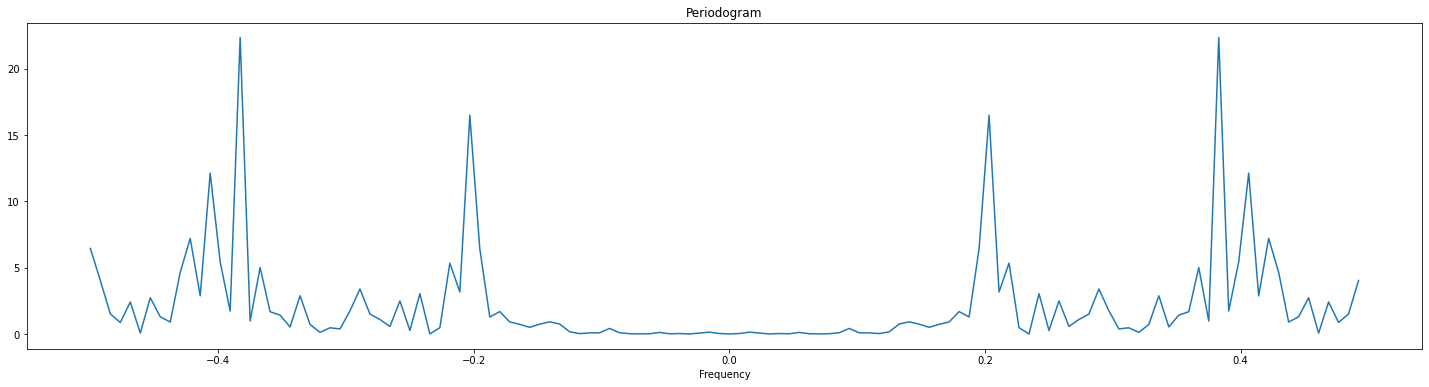

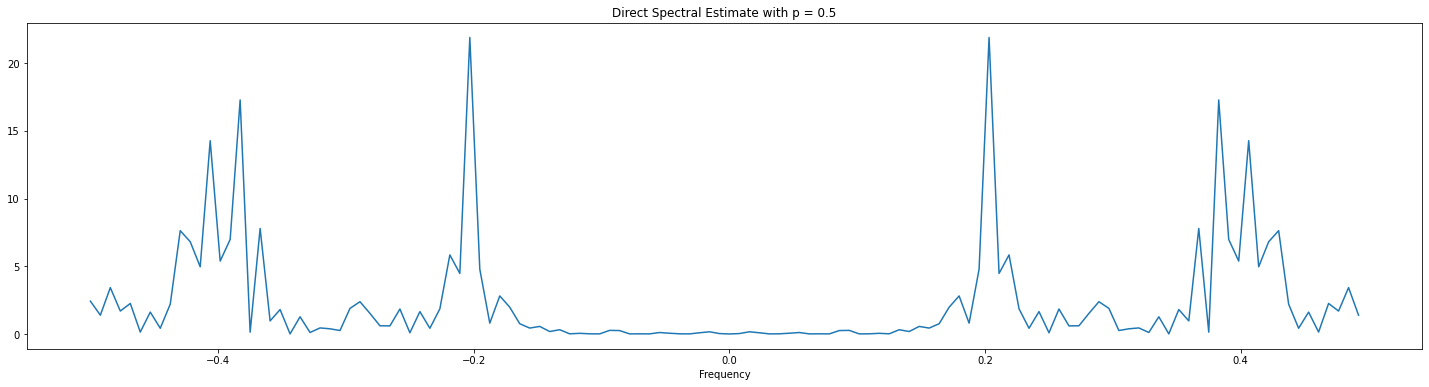

In [391]:
N = len(data)

# array over the range [-1/2, 1/2) with N values
t = np.arange(-N/2, N/2)/N

# plot the periodogram
plt.figure(figsize=(25, 6))
plt.plot(t, fftshift(periodogram(data)))  # we use fftshift so that the range is [-1/2, 1/2)
plt.title("Periodogram")
plt.xlabel("Frequency")
plt.show()

# plot the direct spectral estimate for p = 0.5
plt.figure(figsize=(25, 6))
plt.plot(t, fftshift(direct(data, p = 0.5)))
plt.title("Direct Spectral Estimate with p = 0.5")
plt.xlabel("Frequency")
plt.show()

First we create a function that fits an $AR(p)$ model using the untapered Yule-Walker method.
\begin{equation*}
\hat{\phi}_p = \hat{\Gamma}^{-1}\hat{\gamma}_p \quad \text{ and } \quad \hat{\sigma}^2_p = \hat{s}_0 - \sum_{j=1}^p \hat{\phi}_{i,p} \hat{s}_j,
\end{equation*}
where $\hat{\phi}_p = [\hat{\phi}_{1,p}, \dots, \hat{\phi}_{p,p}]^T$, $\hat{\gamma}_p = [\hat{s}_1, \dots, \hat{s}_p]^T$ and $\hat{\Gamma}_p$ is the Toeplitz matrix as descibed in the notes. We also have that
\begin{equation*}
\hat{s}_\tau = \frac{1}{N} \sum_{t=0}^{N - |\tau| - 1}X_t X_{t + |\tau|}
\end{equation*}
Below we first calculate $s_\tau$ for $\tau = 0, 1, ..., p$ and then find the estimates $\hat{\phi}_p$ and $\hat{\sigma}^2_p$. From these we can then compute the esimate of the sdf using our S_ARMA function from question the Spectral Density Analysis project.

In [392]:
def YW(X, p):
    """
    Input:
        X: Time series data.
        p: parameter of the AR(p) model we fit.
    Output:
        phis: estimated parameters [phi_{1,p}, ..., phi_{p,p}] for the AR(p) model
        sigma2: estimated variance of the white noise. 
    """
    
    N = len(X)

    # initialize array that will contain s_0, s_1, ..., s_p
    s = np.zeros(p+1)

    for i in range(p+1):

        # calculate s_i
        for t in range(N-i):
            s[i] += X[t]*X[t+i]/N

    # construct the matrix Gamma and the vector gamma
    Gamma = toeplitz(s[0:p])
    gamma = s[1:]

    # calculate phis
    phis = np.dot(np.linalg.inv(Gamma), gamma)

    # compute the estimated variance
    sigma2 = s[0] - np.dot(phis, s[1:])
    
    return phis, sigma2

Now we fit a $50$% cosine tapered Yule-Walker model. The steps are almost identical to the previous part, except that our autocovariance sequence is
\begin{equation*}
\hat{s}_\tau = \sum_{t = 0}^{N - |\tau| - 1} h_t X_t h_{t + |\tau|}X_{t + |\tau|}.
\end{equation*}

In [393]:
def YW_tapered(X, p):
    """
    Input:
        X: Time series data
        p: parameter of the AR(p) model
    Output:
        phis: estimated parameters [phi_{1,p}, ..., phi_{p,p}] for the 50% cosine tapered AR(p) model
        sigma2: estimated variance of the white noise.
    """
    
    N = len(X)

    # compute the 50% cosine taper h
    interval = np.arange(0,N)  # range of the taper

    # create the three intervals for the taper
    interval1 = interval[0:int(np.floor(0.5*(N))/2)]
    interval2 = interval[int(np.floor(0.5*(N))/2): N - int(np.floor(0.5*N)/2)]
    interval3 = interval[N - int(np.floor(0.5*N)/2): ]

    # for each interval set the value of h
    h1 = 0.5*(1- np.cos(2*np.pi*(interval1+1)/(np.floor(0.5*N)+1)))
    h2 = np.ones(interval2.shape)
    h3 = 0.5*(1 - np.cos(2*np.pi*(N - interval3)/(np.floor(0.5*N)+1)))
    h = np.concatenate((h1, h2, h3))

    # normalize so that the sum of h_t^2 = 1
    h = h/np.sqrt(np.sum(h**2))
    
    # initialize array that will contain s_0, s_1, ..., s_p
    s = np.zeros(p+1)

    for i in range(p+1):
        # calculate s_i
        for t in range(N-i):
            s[i] += h[t]*X[t]*h[t+i]*X[t+i]
    
    # construct the matrix Gamma and the vector gamma
    Gamma = toeplitz(s[0:p])
    gamma = s[1:]

    # calculate phis
    phis = np.dot(np.linalg.inv(Gamma), gamma)

    # compute the estimated variance
    sigma2 = s[0] - np.dot(phis, s[1:])
    
    return phis, sigma2

We now approximate solution from the maximum likelihood method as described in the notes. We have the following estimates:
\begin{equation*}
\hat{\phi} = (F^TF)^{-1} F^T X, \quad \hat{\sigma}^2_{\epsilon} = \frac{(X - F\hat{\phi})^T(X - F\hat{\phi})}{N-p}
\end{equation*}
From these we can then compute the esimate of the sdf using our S_ARMA function from the Spectral Density Analysis project.

In [394]:
def max_likelihood(X, p):
    """
    Input:
        X: Time series data
        p: parameter of the AR(p) model
    Output:
        phis: estimated parameters [phi_{1,p}, ..., phi_{p,p}] using the maximum likelihood mehtod
        sigma2: estimated variance of the white noise.
    """

    N = len(X)

    
    F = []
    for i in range(N-p):
        F.append(np.flip([X[j] for j in range(i,i+p)]))

    X = X[p:]

    #phis = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(F),F)), np.transpose(F)), X)
    phis = np.linalg.inv(np.transpose(F) @ F) @ np.transpose(F) @ X
    
    sigma2 = np.dot(np.transpose(X - np.dot(F, phis)), (X - np.dot(F, phis))) / (N - p)
    
    return phis, sigma2

In [395]:
def AIC(p, N, sigma2):
    """
    Input:
        p: parameter of AR(p) model
        N: number of elements of data series
        sigma2: estimated variance of the white noise of the process
    Output:
        The AIC of the fitted model.
    """

    return 2*p + N*np.log(sigma2)

In [396]:
# initialize lists that will contain the AIC values for p = 1,...,20
YW_AIC = []
YW_tapered_AIC = []
max_likelihood_AIC = []

# compute the AIC for each p and each model
for p in np.arange(1,21):
    YW_AIC.append(AIC(p, len(data), YW(data, p)[1]))
    YW_tapered_AIC.append(AIC(p, len(data), YW_tapered(data, p)[1]))
    max_likelihood_AIC.append(AIC(p, len(data), max_likelihood(data, p)[1]))

# create table
header = ["p","Yule-Walker", "Yule-Walker tapered", "Maximum Likelihood"]
table = [ [i+1, YW_AIC[i], YW_tapered_AIC[i], max_likelihood_AIC[i]] for i in range(20)]

df = pd.DataFrame(table, columns = header)
df.style.hide(axis='index')

p,Yule-Walker,Yule-Walker tapered,Maximum Likelihood
1,81.973827,88.454376,81.920346
2,69.616089,77.007858,69.992144
3,54.571841,59.477396,54.568978
4,3.607199,-12.379952,-0.568434
5,4.816615,-10.432465,0.813489
6,6.807018,-9.012421,3.245434
7,8.639855,-7.025399,0.832693
8,9.889818,-6.118631,2.084062
9,9.777072,-4.514010,-0.240095
10,11.348643,-2.515384,1.771779


We choose the model which gives the lowest AIC score. For each of the three models we see that the lowest AIC score is for $p = 4$. Below we print the $p+1 = 5$ estimated parameters for each of the three methods.

In [397]:
p = 4

# print Yule-Walker parameters
print("YW phis = ", YW(data, p)[0])
print("YW sigma2 = ", YW(data, p)[1])
print("-"*70)

# print Yule-Walker tapered parametes
print("YW_tapered phis = ", YW_tapered(data, p)[0])
print("YW_tapered sigma2 = ", YW_tapered(data, p)[1])
print("-"*70)

# print Maximum Likelihood parametes
print("max_likelihood phis = ", max_likelihood(data, p)[0])
print("max_likelihood sigma2 = ", max_likelihood(data, p)[1])

YW phis =  [-0.85398062 -0.81334794 -0.73055834 -0.5821149 ]
YW sigma2 =  0.966263452126477
----------------------------------------------------------------------
YW_tapered phis =  [-0.89553519 -0.85480691 -0.80422    -0.66213694]
YW_tapered sigma2 =  0.852810104354746
----------------------------------------------------------------------
max_likelihood phis =  [-0.88252928 -0.84163842 -0.76041087 -0.6071377 ]
max_likelihood sigma2 =  0.935250483838481


We now use our function S_ARMA from question 1 to plot the estimated sdfs from the three methods.

In [398]:
def S_ARMA(f, phis, thetas, sigma2):
    """
    Input: 
        f: list of frequences at which it should be evaluated (must be in the interval [1/2, 1/2))
        phis: the list [phi_{1,p},..., phi_{p,p}]
        thetas: the list [theta_{1,q},..., theta_{q,q}]
        sigma2: a scalar for the variance of the white noise
    Output:
        S: theoretical spectral density function for a ARMA(p,q) process evaluated for each element in f.
    """

    # find p and q
    p = len(phis)
    q = len(thetas)

    # initialize sdf to be zero everywhere
    S = np.zeros(len(f))
    
    # for each element in f, evaluate the sdf
    for i in range(len(f)):            
        # initialize the two sums
        G_theta = 1
        G_phi = 1

        # G_phi = (1 - phi_1*exp(-i*2*pi*f*1) - ... - phi_p*exp(-i*2*pi*f*p))
        for m in range(p):
            G_phi = G_phi - phis[m]*np.e**(-1j*2*np.pi*f[i]*(m+1))
        
        # G_theta = (1 - theta_1*exp(-i*2*pi*f*1) - ... - theta_q*exp(-i*2*pi*f*q))
        for n in range(q):
            G_theta = G_theta - thetas[n]*np.e**(-1j*2*np.pi*f[i]*(n+1))

        # update the ith element of S
        S[i] = sigma2*(abs(G_theta))**2/(abs(G_phi))**2
 
    return S

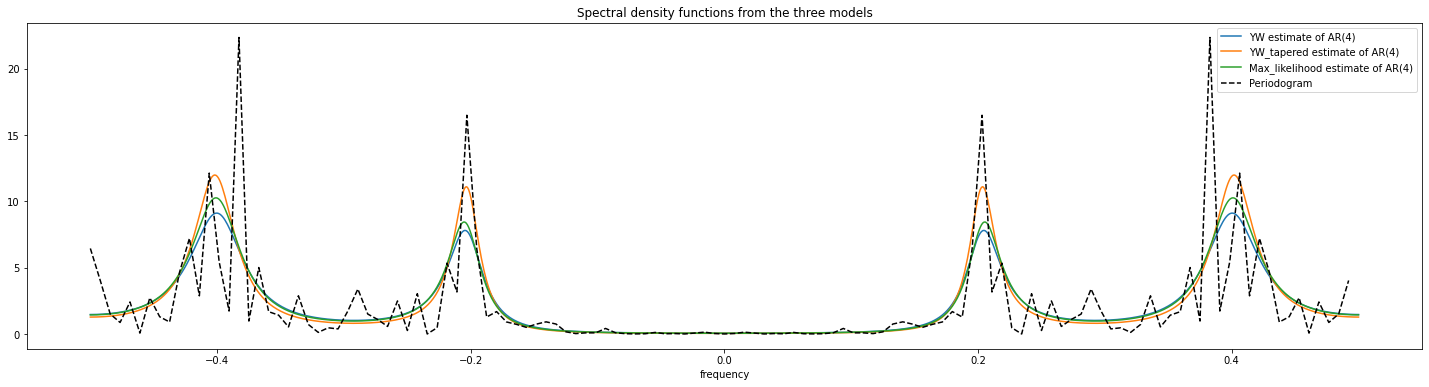

In [399]:
# shifter Fourier frequencies
f = np.arange(-N/2, N/2)/N
t = np.linspace(-1/2, 1/2, 1000)  
p = 4

plt.figure(figsize=(25, 6))

# plot the three estimated sdfs using S_ARMA
plt.plot(t, S_ARMA(t, YW(data, p)[0], [], YW(data, p)[1]), label = f"YW estimate of AR({p})")
plt.plot(t, S_ARMA(t, YW_tapered(data, p)[0], [], YW_tapered(data, p)[1]), label = f"YW_tapered estimate of AR({p})")
plt.plot(t, S_ARMA(t, max_likelihood(data, p)[0], [], max_likelihood(data, p)[1]), label = f"Max_likelihood estimate of AR({p})")
plt.plot(f, fftshift(periodogram(data)), "k--", label = "Periodogram")  # we also plot the periodogram for reference
plt.title("Spectral density functions from the three models")
plt.xlabel("frequency")
plt.legend()
plt.show()

## Forecasting AR(p)

First we determine the parameter $p$ of the $AR$ by using a similar method as before - we compute the AIC for different $p$.

In [400]:
observed_data = data[0:118]

# store the AIC values here
max_likelihood_AIC = []

# compute the AIC for each p and each model
for p in np.arange(1,21):
    max_likelihood_AIC.append(AIC(p, len(observed_data), max_likelihood(observed_data, p)[1]))

# create table
header = ["p", "Maximum Likelihood"]
table = [ [i+1, max_likelihood_AIC[i]] for i in range(20)]

df = pd.DataFrame(table, columns = header)
df.style.hide(axis='index')

p,Maximum Likelihood
1,78.584249
2,67.365125
3,52.736695
4,2.199065
5,4.382445
6,6.849402
7,4.589437
8,6.222231
9,3.991863
10,5.826467


Once again the lowest value is for $p$ is $4$, so we fit the model on the observed data using max likelihood method for $AR(4)$.

In [401]:
# fix p=4
p = 4
observed_data = data[0:118]
phis, sigma2 = max_likelihood(observed_data, p)

In [402]:
def forecast(X, p, phis):
    """
    Input: 
        X: observed data
        p: parameter of the AR(p) process
        phis: the list [phi_{1,p},..., phi_{p,p}]
    Output:
        An array forecasting an AR(p) process of length 10 given observed data.
    """
    
    predicted_data = X[-p: ]
    
    for i in range(10):
        predicted_data.append(np.dot(phis, np.flip(predicted_data[-p: ])))

    # use the last 11 data points so that the prediction is connected to observed data on the plots
    predicted_data = predicted_data[-11:] 

    return predicted_data

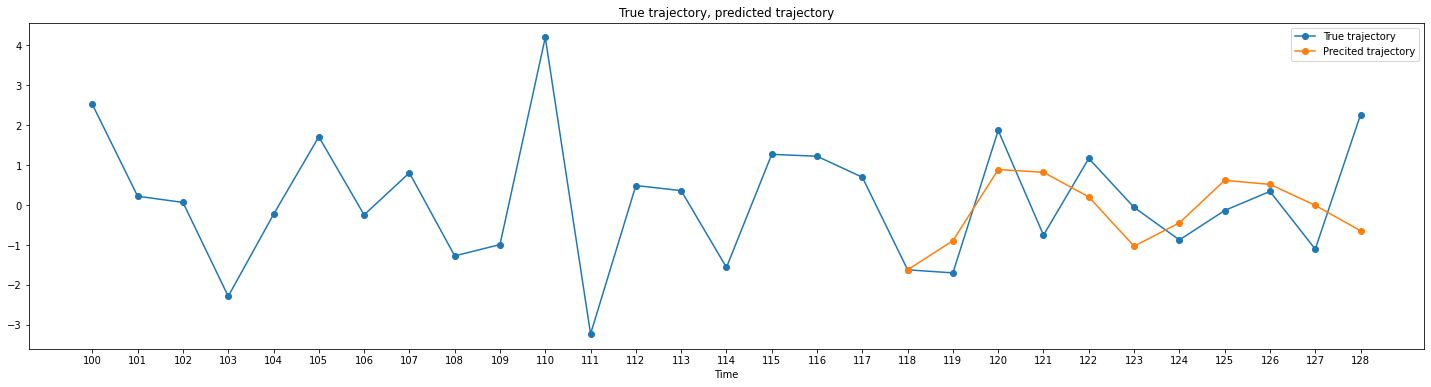

In [403]:
predicted_data = forecast(X=observed_data,
                          p=p,
                          phis=phis)

# plot predicted and true data
plt.figure(figsize=(25, 6))

plt.plot(np.linspace(100, 128, 29), 
         data[99:128], 
         label = "True trajectory", 
         marker="o")

plt.plot(np.linspace(100, 128, 29)[-11:], 
         predicted_data, 
         label = "Precited trajectory", 
         marker="o")

plt.title("True trajectory, predicted trajectory")
plt.xlabel("Time")
plt.xticks(np.linspace(100,128, 29))
plt.legend()
plt.show()

In [404]:
# calculate the absolute difference between the predicted values and the true data
absolute_diff = abs(np.array(data[-12: -1]) - np.array(predicted_data))

# create table
header = ["True trajectory", "Predicted trajectory", "Absolute difference"]
table = [data[-11:], predicted_data, absolute_diff]

df = pd.DataFrame(np.column_stack(table), columns = header)
df.style.hide(axis='index')

True trajectory,Predicted trajectory,Absolute difference
-1.623100,-1.623100,2.320280
-1.700000,-0.893680,0.729420
1.869400,0.889270,2.589270
-0.755030,0.820677,1.048723
1.167000,0.202858,0.957888
-0.058720,-1.030713,2.197713
-0.874310,-0.447165,0.388445
-0.137570,0.618415,1.492725
0.341240,0.517236,0.654806
-1.104900,-0.007743,0.348983


We have created a table to compare the predicted data with the true trajectory. We have also included the absolute difference between the two, to see more clearly how much we have deviated. We can see that our predictions are not very similar to the true data points (although there are some similarities). This is because of the randomness in the nature of the model.

Now we create a function that will simulate the next 10 steps of an $AR(p)$ model given a certain observed data. We then create $999$ simulations and use them to construct a $90%$ prediction interval which we plot together with the true and predicted trajectories.

In [405]:
def AR(X, p, phis, sigma2):
    """
    Input: 
        X: observed data
        p: parameter of the AR(p) process
        phis: the list [phi_{1,p},..., phi_{p,p}]
        sigma2: a scalar for the variance of the white noise
    Output:
        An array simulating an AR(p) process of length 10 given observed data.
    """

    epsilons = np.random.normal(0, np.sqrt(sigma2), 10)
    
    simulation = X
    for i in range(10):
        simulation.append(np.dot(phis, np.flip(simulation[-p:])) + epsilons[i])

    return simulation[-10:]

Now we simulate 1000 times the AR(p) process.

Create confidence interval for prediction.

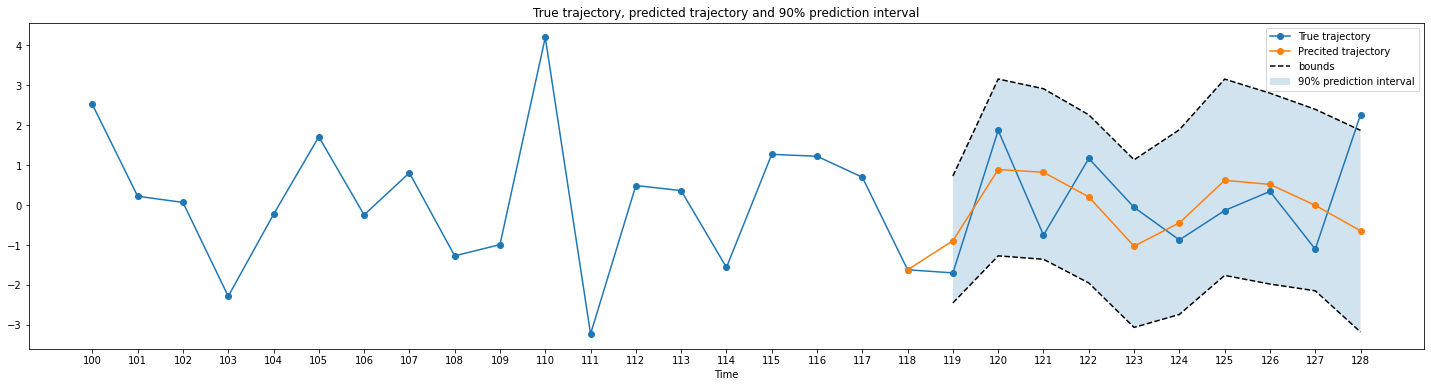

In [406]:
p=4
observed_data = data[0:118]
phis, sigma2 = max_likelihood(X=observed_data,
                              p=p)

# create a matrix where each column contains the simulated data points from the 999 simulation for a single time (10 time points in total)
x_simulation = np.zeros(shape=(1000,10))

for i in range(1000):
    observed_data = data[0:118]
    x_simulation[i] = AR(observed_data, 
                         p, 
                         phis=phis,
                         sigma2=sigma2)

# compute the lower and upper bound trajectories
x_simulation_sorted = np.transpose(np.sort(np.transpose(x_simulation)))
lower_bounds = x_simulation_sorted[50, :]
upper_bounds = x_simulation_sorted[-50, :]

# plot the true trajectory, the predicted trajectory and the 90% prediction interval
plt.figure(figsize=(25, 6))

plt.plot(np.linspace(100,128, 29), 
         data[99:128], 
         label = "True trajectory", 
         marker="o")

plt.plot(np.linspace(100, 128, 29)[-11:], 
         predicted_data, 
         label = "Precited trajectory", 
         marker="o")

plt.plot(range(119, 129), upper_bounds, 'k--', label='bounds')
plt.plot(range(119, 129), lower_bounds, 'k--')

plt.fill_between(np.linspace(100, 128, 29)[-10:], 
                 lower_bounds, 
                 upper_bounds, 
                 alpha = 0.2, 
                 label = "90% prediction interval")

plt.title("True trajectory, predicted trajectory and 90% prediction interval")
plt.xlabel("Time")
plt.xticks(np.linspace(100,128, 29))
plt.legend()
plt.show()